Bernstein–Vazarani Algorithm:

The structure of the oracle for this problem is one where $a$ is represented with qubits in a definite state. Then we compute the dot product between the output qubit and each of the bits in $a$ to get the actual output. The goal of this algorithm is to determine the original bitstring, $a$, in as few runs as possible. This is done by transferring each bit of $a$ to an output qubit. This dot-product is computed with CNOT gates, with the control on the bitstrings and the target on the output, and is the same as the dot product between each bit of $a$ and the output qubit mod 2. This is somewhat helpful as it tells you if there is an even or odd number of 1's in $a$. We can do better though.

Note that we may know or not know $a$, it is simply built into the code of the algorithm using CNOT gates which we may manipulate using a series of other gates. The input qubits simply act to facilitate the computation of the dot product by interacting with CNOT gates, and their actually statevector is not important. 

1's are encoded through CNOT gates, as mentioned before. We can flip the CNOT gate using Hadamard gates to turn each of the input bits of $a$ as well as the output register before and after the Dot-Product computation. This makes it so that wherever there is a CNOT, it will be flipped and will be guarenteed to be shown in the input register. We also set up the input qubits in the 0 state, and the output into the 1 state. This will make it so that everytime there is a CNOT that bit of $a$ goes to the corresponding input qubit with 100% certainty that we will measure it. 

Below we will begin by writing code to generate a random bitstring $a$.

In [50]:
# RNG
import random
#Numpy
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import time

In [75]:
def generate_a(bits): #Generates a with a length of n-1 where n is the total number of qubits in the cicuit
    a_list = []
    for bit in range(bits-1):
        add = random.randint(0,1)
        a_list.append(add)
    return a_list # a_list is the one that will be used in circuit

def list_to_string(lis):
    string = ""
    for item in lis:
        string = string + str(item)
    return string



Above the string $a$ is made and we are now ready to setup the basic quantum circuit.

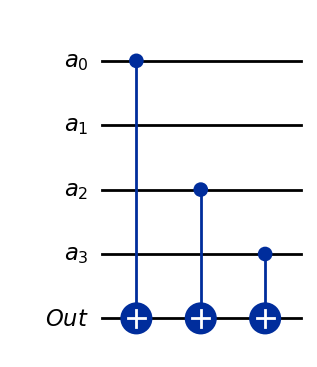

In [112]:
#Setup

qubits = 5
cbits = 1
a = generate_a(qubits)

Input = QuantumRegister(qubits-1, "a")
Output = QuantumRegister(1, "Out")

BVC = QuantumCircuit(Input, Output)

#Oracle, when there is a 1 insert a CNOT between 
for index, bit in enumerate(a):
    if bit == 1:
        BVC.cx(Input[index],Output[0]) 

BVC.draw("mpl")

When you run the above code, you will see a circuit pop up. This is the simple, basic version of the circuit which we will now add hadamards to and flip the CNOTs in order to actually determine $a$. Below we will now add the Hadamards.

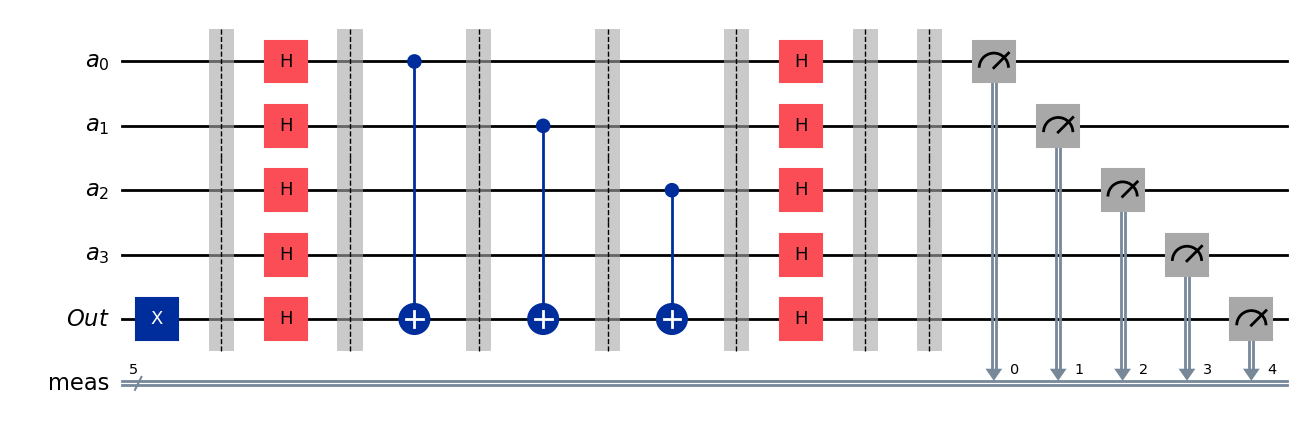

In [146]:
#Setup

qubits = 5
cbits = 1
a = generate_a(qubits)

Input = QuantumRegister(qubits-1, "a")
Output = QuantumRegister(1, "Out")

BVC = QuantumCircuit(Input, Output)

# The output qubit must be in the 1 state, all others must be in the 0 (defaults to this)
BVC.x(Output[0])
BVC.barrier()

# Adding Hadamards before Oracle

for bits in range(qubits):
    BVC.h(bits)
BVC.barrier()

# Oracle, when there is a 1 insert a CNOT between 
for index, bit in enumerate(a):
    if bit == 1:
        BVC.cx(Input[index],Output[0]) 
        BVC.barrier()

# Adding Hadamards after Oracle

for bits in range(qubits):
    BVC.h(bits)
BVC.barrier()
BVC.measure_all()

BVC.draw("mpl")

Okay cool, now that we have the actual circuit made, we can run it and we would theoretically get an answer. But we want to be efficient, so instead of having a bunch of hadamard gates, we can flip the CNOTs using the hadamard-CNOT relation. Then we will run the algorithm to see what we obtain.

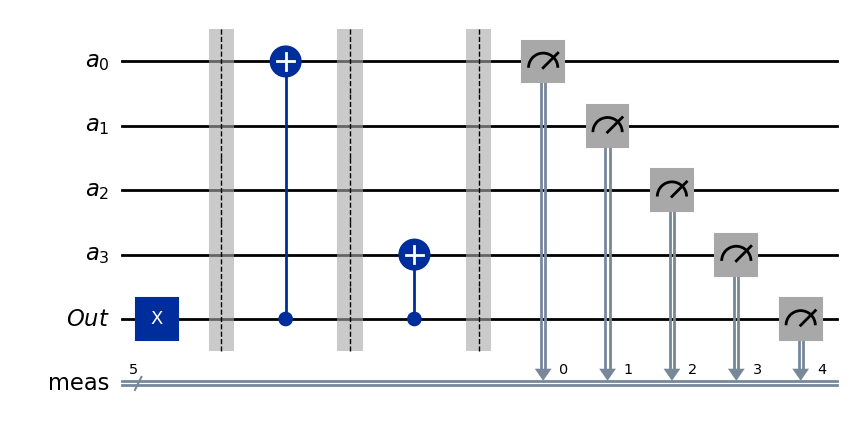

In [147]:
#Setup

qubits = 5
cbits = 1
a = generate_a(qubits)

Input = QuantumRegister(qubits-1, "a")
Output = QuantumRegister(1, "Out")

BVC = QuantumCircuit(Input, Output)

# The output qubit must be in the 1 state, all others must be in the 0 (defaults to this)
BVC.x(Output[0])

# Oracle, when there is a 1 insert a CNOT between 
for index, bit in enumerate(a):
    if bit == 1:
        BVC.barrier()
        BVC.cx(Output[0], Input[index]) 
        
BVC.measure_all()

BVC.draw("mpl")

Above is the flipped version which will be the final one we will use to compute $a$. Note that the last bit of the output bitstring is not important as it will always be 1.

1100


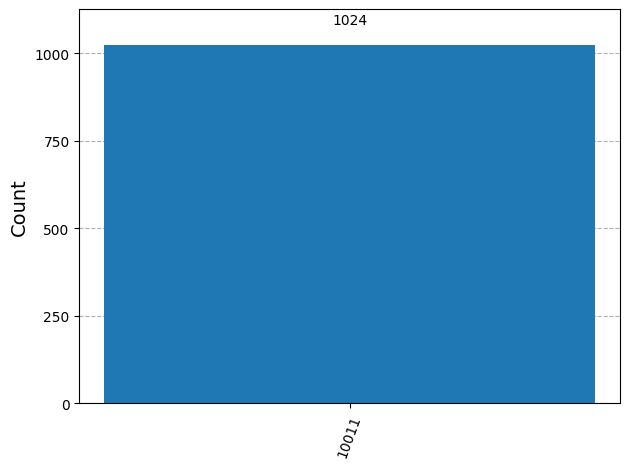

In [153]:
#Setup

qubits = 5
cbits = 1
a = generate_a(qubits)
print(list_to_string(a))

Input = QuantumRegister(qubits-1, "a")
Output = QuantumRegister(1, "Out")

BVC = QuantumCircuit(Input, Output)

# The output qubit must be in the 1 state, all others must be in the 0 (defaults to this)
BVC.x(Output[0])

# Oracle, when there is a 1 insert a CNOT between 
for index, bit in enumerate(a):
    if bit == 1:
        BVC.barrier()
        BVC.cx(Output[0], Input[index]) 
        
BVC.measure_all()

simulator = AerSimulator()
transpiled_BVC = transpile(BVC,simulator)
results = simulator.run(transpiled_BVC).result()
plot_histogram(results.get_counts())

To read the value of $a$, find the output measured value (example being 10101 under the histogram bar) then remove the leftmost 1, then flip the order of the digits. So we go from 10101 to 0101 to 1010 which is $a$.